From Dan Simon's "Optimal State Estimation", question 5.2: show why Joseph form on calculating posteriori covariance is stable but the simplified version is not. Here, assume a scalar case. Drop the subscription $k$. 

## Joseph form

$$P^+ = (1-KH)P^-(1-KH)^T + KR^-K^T$$

Follow the instruction from question 5.2 on computing partial derivative w.r.t $K$

$$\begin{aligned}
&\frac{\partial P^+}{\partial K} \\
=&(1-KH)P^-(-H^T) + (-H)P^-(1-KH) + KR + RK^T \\
\end{aligned}
$$

Since scalar, $(1-KH)^T = 1-KH$, $H^T=H$ and $K^T=K$. Hence

$$\begin{aligned}
&\frac{\partial P^+}{\partial K} \\
=&-2(1-KH)P^-H + 2KR \\
=&-2P^-H + 2KHP^-H + 2KR \\
=&-2P^-H + 2K(HP^-H + R) \\
\end{aligned}
$$

Since $K=P^-H(HP^-H+R)^{-1}$. Plug this $K$ into above equation

$$\begin{aligned}
&\frac{\partial P^+}{\partial K} \\
=&-2P^-H + 2P^-H(HP^-H+R)^{-1}(HP^-H + R) \\
=&-2P^-H + 2P^-H \\
=&0
\end{aligned}
$$

Hence, $P^+$ is *not senstive* to the change (computing error, rounding error, etc) of $K$.

## Non-Joseph form

$$P^+ = (1-KH)P^-$$

$$\begin{aligned}
&\frac{\partial P^+}{\partial K} \\
=&-HP^- \\
\ne& 0
\end{aligned}
$$

Hence, $P^+$ is *senstive* to the change $K$.

## Simulation 1. Plot $P^+$ by perturbing $K$ in one time step

In [1]:
import numpy as np
import matplotlib.pyplot as plt
def Kalman_gain(P_priori, H, R):
    K = P_priori * H / (H * P_priori * H + R)
    return K

def Joseph_P_post(P_priori, H, R, K):
    P_posteriori = (1-K*H) * P_priori * (1-K*H) + K * R * K
    return P_posteriori

def non_Joseph_P_post(P_priori, H, R, K):
    P_posteriori = (1-K*H) * P_priori
    return P_posteriori

P_priori = 2.0
H = 0.8
R = 0.1
K = Kalman_gain(P_priori, H, R)
print('Kalman gain is: ', K)
print('Estimate (co)variance is: ', Joseph_P_post(P_priori, H, R, K))

Kalman gain is:  1.1594202898550723
Estimate (co)variance is:  0.14492753623188404


### Perturbe $K$ in one time step

Text(0, 0.5, 'Estimate (co)variance posteriori')

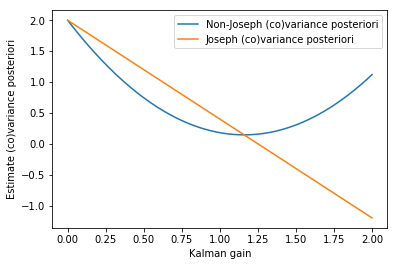

In [2]:
K_pert = np.linspace(0, 2, 100)
P_post_pert_Joseph = Joseph_P_post(P_priori, H, R, K_pert)
P_post_pert_non_Joseph = non_Joseph_P_post(P_priori, H, R, K_pert)
plt.figure(1)
plt.plot(K_pert, P_post_pert_Joseph)
plt.plot(K_pert, P_post_pert_non_Joseph)
plt.legend({'Joseph (co)variance posteriori', 'Non-Joseph (co)variance posteriori'})
plt.xlabel('Kalman gain')
plt.ylabel('Estimate (co)variance posteriori')

It can be seen that the variance slope at around true Kalman gain $1.24$ is different. The Joseph form variance slop is $0$; the non-Joseph form slope is negative.

## Simulation 2. Plot $P^+$ w.r.t. error rounded $K$ in multiple time steps

Assume $K$ is rounded. For this motion model

$$
x(k+1) = F x(k) + (-0.3) + w(k) \\
y(k) = Hx(k) + v(k)
$$

Text(0, 0.5, 'Estimated x')

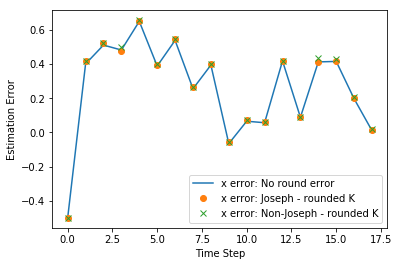

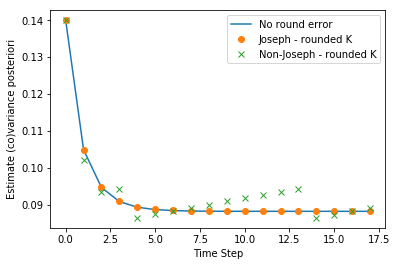

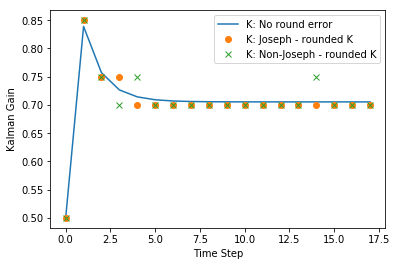

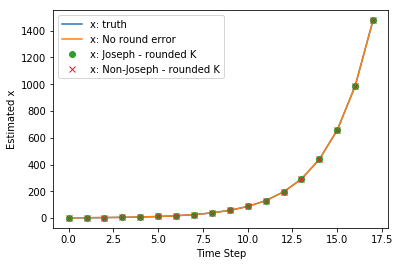

In [57]:
T = 18
Q = 0.004
F = 1.5
round_base = 0.05
u = -0.0

# general x truth
x_truth = np.zeros(T)
y_truth = np.zeros(T)
x_truth[0] = 1.5
for i in range(1, T):
    x_truth[i] = F * x_truth[i-1] + u

y_truth = H * x_truth
y = y_truth + np.random.normal(0,np.sqrt(R), T)

x0 = 1.0
P0 = 0.14
K0 = 0.5

## simulate
x_Joseph_T = np.zeros(T)
x_Joseph_T[0] = x0
P_Joseph_T = np.ones(T)
P_Joseph_T[0] = P0
K_Joseph_T = np.zeros(T)
K_Joseph_T[0] = K0
for i in range(1, T):
    # predict
    P_p = F * P_Joseph_T[i-1] * F + Q
    x_Joseph_T[i] = F * x_Joseph_T[i-1] + u
    # correct
    K_Joseph_T[i] = Kalman_gain(P_p, H, R)
    P_Joseph_T[i] = Joseph_P_post(P_p, H, R, K_Joseph_T[i])
    x_Joseph_T[i] = x_Joseph_T[i] + K_Joseph_T[i] * (y[i] - H * x_Joseph_T[i])

x_Joseph_T_rounded = np.zeros(T)
x_Joseph_T_rounded[0] = x0
P_Joseph_T_rounded = np.zeros(T)
P_Joseph_T_rounded[0] = P0
K_Joseph_T_rounded = np.zeros(T)
K_Joseph_T_rounded[0] = K0
for i in range(1, T):
    # predict
    P_p = F * P_Joseph_T_rounded[i-1] * F + Q
    x_Joseph_T_rounded[i] = F * x_Joseph_T_rounded[i-1] + u
    # correct
    K_temp = Kalman_gain(P_p, H, R)
    K_Joseph_T_rounded[i] = round_base * round(K_temp/round_base)
    P_Joseph_T_rounded[i] = Joseph_P_post(P_p, H, R, K_Joseph_T_rounded[i])
    x_Joseph_T_rounded[i] = x_Joseph_T_rounded[i] + K_Joseph_T_rounded[i] * \
        (y[i] - H * x_Joseph_T_rounded[i])

x_non_Joseph_T_rounded = np.zeros(T)
x_non_Joseph_T_rounded[0] = x0
P_non_Joseph_T_rounded = np.zeros(T)
P_non_Joseph_T_rounded[0] = P0
K_non_Joseph_T_rounded = np.zeros(T)
K_non_Joseph_T_rounded[0] = K0
for i in range(1, T):
    # predict
    P_p = F * P_non_Joseph_T_rounded[i-1] * F + Q
    x_non_Joseph_T_rounded[i] = F * x_non_Joseph_T_rounded[i-1] + u
    # correct
    K_temp = Kalman_gain(P_p, H, R)
    K_non_Joseph_T_rounded[i] = round_base * round(K_temp/round_base)
    P_non_Joseph_T_rounded[i] = non_Joseph_P_post(P_p, H, R, K_non_Joseph_T_rounded[i])
    x_non_Joseph_T_rounded[i] = x_non_Joseph_T_rounded[i] + K_non_Joseph_T_rounded[i] * \
        (y[i] - H * x_non_Joseph_T_rounded[i])

plt.figure(2)
ax_xe = plt.subplot(111)
ax_xe.plot(x_Joseph_T-x_truth, label='x error: No round error')
ax_xe.plot(x_Joseph_T_rounded-x_truth, 'o', label='x error: Joseph - rounded K')
ax_xe.plot(x_non_Joseph_T_rounded-x_truth, 'x', label='x error: Non-Joseph - rounded K')
ax_xe.legend()
ax_xe.set_xlabel('Time Step')
ax_xe.set_ylabel('Estimation Error')

plt.figure(3)
ax_cov = plt.subplot(111)
ax_cov.plot(P_Joseph_T, label='No round error')
ax_cov.plot(P_Joseph_T_rounded, 'o', label='Joseph - rounded K')
ax_cov.plot(P_non_Joseph_T_rounded, 'x', label='Non-Joseph - rounded K')
ax_cov.legend()
ax_cov.set_xlabel('Time Step')
ax_cov.set_ylabel('Estimate (co)variance posteriori')

plt.figure(4)
ax_K = plt.subplot(111)
ax_K.plot(K_Joseph_T, label='K: No round error')
ax_K.plot(K_Joseph_T_rounded, 'o', label='K: Joseph - rounded K')
ax_K.plot(K_non_Joseph_T_rounded, 'x', label='K: Non-Joseph - rounded K')
ax_K.legend()
ax_K.set_xlabel('Time Step')
ax_K.set_ylabel('Kalman Gain')

plt.figure(5)
ax_x = plt.subplot(111)
ax_x.plot(x_truth, label='x: truth')
ax_x.plot(x_Joseph_T, label='x: No round error')
ax_x.plot(x_Joseph_T_rounded, 'o', label='x: Joseph - rounded K')
ax_x.plot(x_non_Joseph_T_rounded, 'x', label='x: Non-Joseph - rounded K')
ax_x.legend()
ax_x.set_xlabel('Time Step')
ax_x.set_ylabel('Estimated x')